In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet50

In [2]:
# Set the random seed for PyTorch and NumPy to ensure reproducibility of results
torch.manual_seed(42)
np.random.seed(42)

# Define the batch size and image size for the dataset
BATCH_SIZE = 16
#IMAGE_SIZE = (256, 256)

In [3]:
# Define the classes and directories for the training and testing data
CLASSES = {
    0: "turtle",
    1: "penguin",
}
train_directory = "archive/train/train"
test_directory = "archive/valid/valid"

In [4]:
# Create a list of file paths for the training and testing data, sorted in alphabetical order
train_paths = sorted(os.path.join(train_directory, file) for file in os.listdir(train_directory))
test_paths = sorted(os.path.join(test_directory, file) for file in os.listdir(test_directory))

def preprocess_annotations(path):
    """
    Read a JSON file and replace the category ID with 0 if it is equal to 2.

    Args:
        path (str): The path to the JSON file.

    Returns:
        pandas.DataFrame: The preprocessed annotations.
    """
    df = pd.read_json(path)
    df["category_id"] = df["category_id"].replace(2, 0)
    return df

# Use the preprocess_annotations function to read JSON files and preprocess the annotations
train_annotations = preprocess_annotations('archive/train_annotations')
test_annotations = preprocess_annotations('archive/valid_annotations')

# Display the first five rows of the train_annotations dataframe
train_annotations.head()

,id,image_id,category_id,bbox,area,segmentation,iscrowd
0,0,0,1,"[119, 25, 205, 606]",124230,[],0
1,1,1,1,"[131, 82, 327, 440]",143880,[],0
2,2,2,0,"[225, 298, 198, 185]",36630,[],0
3,3,3,0,"[468, 109, 172, 193]",33196,[],0
4,4,4,1,"[14, 242, 611, 154]",94094,[],0


In [6]:
# Resize the images to the specified size
#resizer = transforms.Resize(IMAGE_SIZE)

In [8]:
# Define the PenguinTurtleDataset class
class PenguinTurtleDataset(Dataset):
    def __init__(self, image_paths, annotations, transform=None):
        self.image_paths = image_paths
        self.annotations = annotations
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Get the image path, label, and bounding box for the current index
        image_path = self.image_paths[idx]
        label = self.annotations["category_id"].iloc[idx]
        bbox = self.annotations["bbox"].iloc[idx]

        # Open the image and convert it to RGB format
        image = Image.open(image_path).convert("RGB")

        # Resize the image to the specified size
        #image = resizer(image)

        # Apply the specified transform to the image
        if self.transform:
            image = self.transform(image)

        # Return the image, label, and bounding box as a tuple
        return image, label, torch.Tensor(bbox)//2.5

In [9]:
# Resize the images to the specified size and apply random horizontal flip to the training data
train_transform = transforms.Compose([
    #resizer,
    transforms.Resize(256),
    transforms.ToTensor(),
])

# Resize the images to the specified size for the testing data
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
])

In [10]:
# Create the PenguinTurtleDataset objects for the training and testing data
train_dataset = PenguinTurtleDataset(train_paths, train_annotations, transform=train_transform)

test_dataset = PenguinTurtleDataset(test_paths, test_annotations, transform=test_transform)

# Create the DataLoader objects for the training and testing data
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
!pip install resnet_pytorch

In [11]:
# Load the pre-trained ResNet-50 model
resnet = resnet50(pretrained=True)

# Image classification model
class ClassificationModel(nn.Module):
    def __init__(self, num_classes):
        super(ClassificationModel, self).__init__()
        self.resnet = resnet
        self.fc = nn.Linear(1000, num_classes)
    
    def forward(self, x):
        features = self.resnet(x)
        output = self.fc(features)
        return output

# Object detection model
class DetectionModel(nn.Module):
    def __init__(self):
        super(DetectionModel, self).__init__()
        self.resnet = resnet
        self.fc_regression = nn.Linear(1000, 4)

    
    def forward(self, x):
        features = self.resnet(x)       
        regression_output = self.fc_regression(features)

        return  regression_output

/Users/yz/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/yz/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate models and move to device
model_classification = ClassificationModel(num_classes=2).to(device)
model_detection = DetectionModel().to(device)

# Define loss functions and optimizers
criterion_classification = nn.CrossEntropyLoss()
criterion_detection = nn.SmoothL1Loss()
optimizer_classification = optim.Adam([{'params':model_classification.resnet.parameters(),'lr':1e-4},
                                       {'params':model_classification.fc.parameters()}], lr=1e-4)
optimizer_detection = optim.Adam(model_detection.parameters(), lr=0.001)

# Train models
num_epochs = 100
best_acc = 0.0
best_loss = float('inf')
train_losses_classification = []
train_losses_detection = []
train_accs = []
for epoch in range(num_epochs):
    running_loss_classification = 0.0
    running_loss_detection = 0.0
    running_corrects = 0
    for i,(images, labels, bboxes) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        bboxes = bboxes.to(device)

        # Train classification model
        optimizer_classification.zero_grad()
        outputs_classification = model_classification(images)
        loss_classification = criterion_classification(outputs_classification, labels)
        loss_classification.backward()
        if i%1 == 0 or i == len(train_dataloader)-1:
            optimizer_classification.step()

        # Train object detection model
        optimizer_detection.zero_grad()
        outputs_detection = model_detection(images)
        loss_detection = criterion_detection(outputs_detection, bboxes)
        loss_detection.backward()
        optimizer_detection.step()

        # Calculate loss and accuracy
        running_loss_classification += loss_classification.item() * images.size(0)
        running_loss_detection += loss_detection.item() * images.size(0)
        _, preds = torch.max(outputs_classification, 1)
        running_corrects += torch.sum(preds == labels.data)

    # Calculate loss and accuracy
    epoch_loss_classification = running_loss_classification / len(train_dataset)
    epoch_loss_detection = running_loss_detection / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    # Save best models
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        torch.save(model_classification.state_dict(), 'best_classification_model.pth')
    if epoch_loss_detection < best_loss:
        best_loss = epoch_loss_detection
        torch.save(model_detection.state_dict(), 'best_detection_model.pth')

    # Print loss and accuracy for each epoch
    print('Epoch [{}/{}], Classification Loss: {:.4f}, Detection Loss: {:.4f}, Classification Acc: {:.4f}'
          .format(epoch+1, num_epochs, epoch_loss_classification, epoch_loss_detection, epoch_acc))

    # Save losses
    train_losses_classification.append(epoch_loss_classification)
    train_losses_detection.append(epoch_loss_detection)
    train_accs.append(epoch_acc)


Epoch [1/100], Classification Loss: 1.6313, Detection Loss: 119.0337, Classification Acc: 0.5480
Epoch [2/100], Classification Loss: 1.2270, Detection Loss: 106.7001, Classification Acc: 0.5360
Epoch [3/100], Classification Loss: 1.0246, Detection Loss: 105.6403, Classification Acc: 0.5420
Epoch [4/100], Classification Loss: 0.8258, Detection Loss: 104.7469, Classification Acc: 0.6320
Epoch [5/100], Classification Loss: 1.0330, Detection Loss: 105.0025, Classification Acc: 0.6160
Epoch [6/100], Classification Loss: 0.9712, Detection Loss: 104.0759, Classification Acc: 0.6140
Epoch [7/100], Classification Loss: 0.8121, Detection Loss: 101.0416, Classification Acc: 0.6880
Epoch [8/100], Classification Loss: 0.7841, Detection Loss: 96.8332, Classification Acc: 0.6800
Epoch [9/100], Classification Loss: 0.8018, Detection Loss: 94.9151, Classification Acc: 0.7420
Epoch [10/100], Classification Loss: 0.7473, Detection Loss: 93.8918, Classification Acc: 0.6880
Epoch [11/100], Classification L

Epoch [86/100], Classification Loss: 0.0326, Detection Loss: 39.2533, Classification Acc: 0.9840
Epoch [87/100], Classification Loss: 0.0525, Detection Loss: 39.8740, Classification Acc: 0.9820
Epoch [88/100], Classification Loss: 0.0489, Detection Loss: 39.9222, Classification Acc: 0.9840
Epoch [89/100], Classification Loss: 0.0227, Detection Loss: 38.8937, Classification Acc: 0.9880
Epoch [90/100], Classification Loss: 0.0998, Detection Loss: 41.3878, Classification Acc: 0.9700
Epoch [91/100], Classification Loss: 0.1899, Detection Loss: 44.0751, Classification Acc: 0.9680
Epoch [92/100], Classification Loss: 0.0101, Detection Loss: 37.7145, Classification Acc: 0.9960
Epoch [93/100], Classification Loss: 0.0876, Detection Loss: 37.1536, Classification Acc: 0.9780
Epoch [94/100], Classification Loss: 0.3525, Detection Loss: 42.6657, Classification Acc: 0.9500
Epoch [95/100], Classification Loss: 0.0765, Detection Loss: 38.7889, Classification Acc: 0.9780
Epoch [96/100], Classification

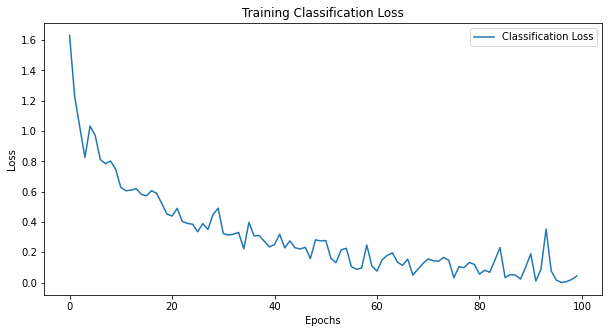

In [17]:
# Plot classification loss
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_losses_classification, label="Classification Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Classification Loss")
plt.legend()
plt.show()

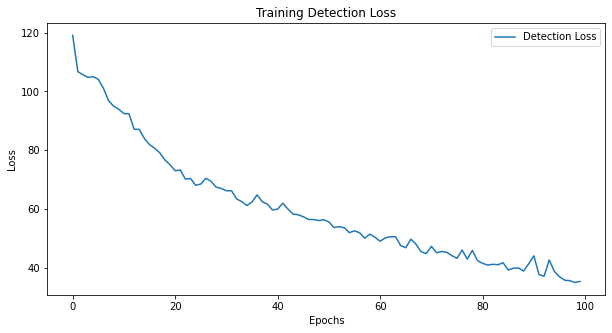

In [18]:
# Plot Detection Loss
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_losses_detection, label="Detection Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Detection Loss")
plt.legend()
plt.show()

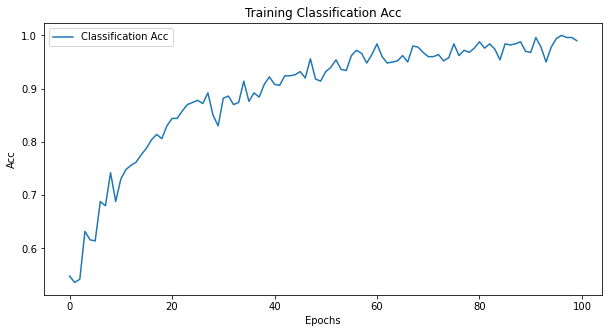

In [21]:
# Plot Classification Acc
plt.figure(figsize=(10, 5))
train_accs_tensor = torch.tensor(train_accs)
plt.plot(range(num_epochs), train_accs_tensor.cpu(), label="Classification Acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Training Classification Acc")
plt.legend()
plt.show()

In [11]:
def calculate_iou(box1, box2):
    """
    Calculate the intersection over union (IoU) of two bounding boxes.
    """
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    area1 = w1 * h1
    area2 = w2 * h2
    xmin = max(x1 - w1 / 2, x2 - w2 / 2)
    ymin = max(y1 - h1 / 2, y2 - h2 / 2)
    xmax = min(x1 + w1 / 2, x2 + w2 / 2)
    ymax = min(y1 + h1 / 2, y2 + h2 / 2)
    inter_area = max(0, xmax - xmin) * max(0, ymax - ymin)
    iou = inter_area / (area1 + area2 - inter_area)
    return iou

In [16]:
# Define the number of classes
num_classes = 2

# Define the loss functions
criterion_classification = nn.CrossEntropyLoss()
criterion_detection = nn.SmoothL1Loss()

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained models
loaded_model_classification = ClassificationModel(num_classes=2).to(device)
loaded_model_detection = DetectionModel().to(device)
loaded_model_classification.load_state_dict(torch.load('best_classification_model.pth'))
loaded_model_detection.load_state_dict(torch.load('best_detection_model.pth'))

# Set the models to evaluation mode
loaded_model_classification.eval()
loaded_model_detection.eval()

# Initialize variables
running_loss_classification = 0.0
running_loss_detection = 0.0
running_corrects = 0
detection_distances = []
detection_ious = []
confusion_matrix = torch.zeros(num_classes, num_classes)

# Test the models on the test dataset
for images, labels, bboxes in test_dataloader:
    images = images.to(device)
    labels = labels.to(device)
    bboxes = bboxes.to(device)

    # Forward pass
    with torch.no_grad():
        outputs_classification = loaded_model_classification(images)
        outputs_detection = loaded_model_detection(images)

    # Calculate loss and accuracy
    loss_classification = criterion_classification(outputs_classification, labels)
    loss_detection = criterion_detection(outputs_detection, bboxes)
    running_loss_classification += loss_classification.item() * images.size(0)
    running_loss_detection += loss_detection.item() * images.size(0)
    _, preds = torch.max(outputs_classification, 1)
    running_corrects += torch.sum(preds == labels.data)

    # Calculate detection performance
    for i in range(images.size(0)):
        detection_distance = torch.norm(outputs_detection[i][:2] - bboxes[i][:2])
        detection_distances.append(detection_distance.item())
        detection_iou = calculate_iou(outputs_detection[i], bboxes[i])
        detection_ious.append(detection_iou.item())

    # Calculate classification performance
    for t, p in zip(labels.view(-1), preds.view(-1)):
        confusion_matrix[t.long(), p.long()] += 1

# Calculate loss and accuracy
test_loss_classification = running_loss_classification / len(test_dataset)
test_loss_detection = running_loss_detection / len(test_dataset)
test_acc = running_corrects.double() / len(test_dataset)

# Calculate detection performance metrics
detection_mean_distance = torch.tensor(detection_distances).mean().item()
detection_std_distance = torch.tensor(detection_distances).std().item()
detection_mean_iou = torch.tensor(detection_ious).mean().item()
detection_std_iou = torch.tensor(detection_ious).std().item()

# Calculate classification performance metrics
confusion_matrix = confusion_matrix.numpy()
accuracy = np.trace(confusion_matrix) / np.sum(confusion_matrix)
precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
f1_score = np.mean(2 * precision * recall / (precision + recall))

# Print the test results
print('Test Classification Loss: {:.4f}, Detection Loss: {:.4f}, Classification Acc: {:.4f}'
      .format(test_loss_classification, test_loss_detection, test_acc))
print('Detection Mean Distance: {:.4f}, Detection Std Distance: {:.4f}, Detection Mean IoU: {:.4f}, Detection Std IoU: {:.4f}'
      .format(detection_mean_distance, detection_std_distance, detection_mean_iou, detection_std_iou))
print('Confusion Matrix:\n', confusion_matrix)
print('Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}'
      .format(accuracy, np.mean(precision), np.mean(recall), f1_score))

Test Classification Loss: 1.8149, Detection Loss: 69.8997, Classification Acc: 0.8194
Detection Mean Distance: 94.7468, Detection Std Distance: 56.7428, Detection Mean IoU: 0.4049, Detection Std IoU: 0.2034
Confusion Matrix:
 [[35.  1.]
 [12. 24.]]
Accuracy: 0.8194, Precision: 0.8523, Recall: 0.8194, F1 Score: 0.8151


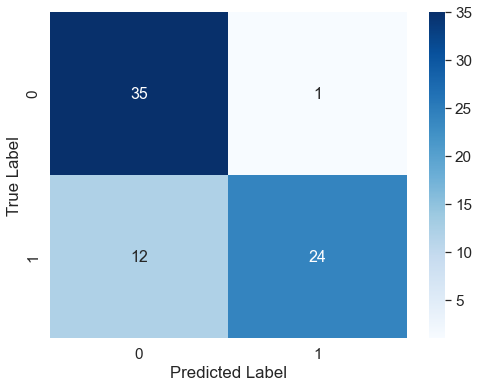

In [17]:
import seaborn as sns

# Set figure size and font scale
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4)

# Plot the confusion matrix as a heatmap
sns.heatmap(confusion_matrix, annot=True, annot_kws={"size": 16}, cmap="Blues", fmt='g')

# Set the x and y labels
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

In [11]:
# Define the test dataset and transform
test_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_dataset = PenguinTurtleDataset(test_paths, test_annotations, transform=test_transform)

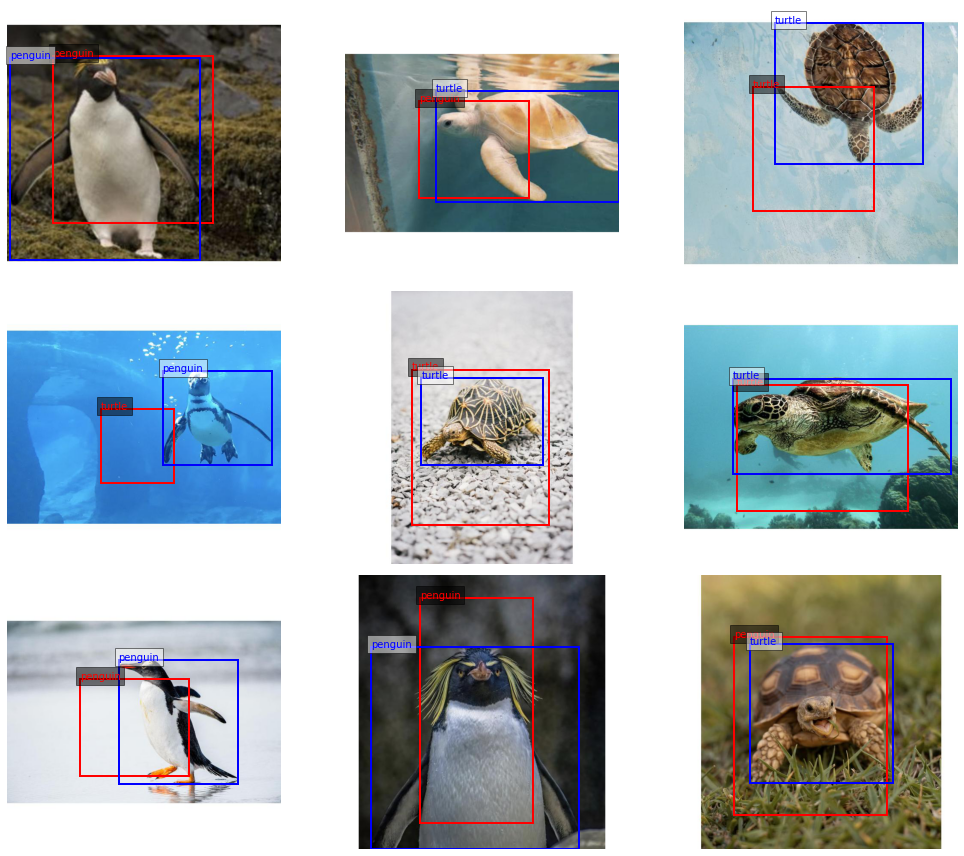

In [13]:
# Define the number of images to display
num_images = 9
random_indices = np.random.choice(len(test_dataset), num_images, replace=False)

# Load the model
loaded_model_classification = ClassificationModel(num_classes=2).to(device)
loaded_model_detection = DetectionModel().to(device)
loaded_model_classification.load_state_dict(torch.load('best_classification_model.pth'))
loaded_model_detection.load_state_dict(torch.load('best_detection_model.pth'))

# Set the model to evaluation mode
loaded_model_classification.eval()
loaded_model_detection.eval()

# Define the colors for predicted and true bounding boxes
pred_bbox_color = 'red'
true_bbox_color = 'blue'

# Plot the predicted and true bounding boxes
plt.figure(figsize=(15, 12))
for i, idx in enumerate(random_indices):
    image, label, bbox = test_dataset[idx]
    image = image.unsqueeze(0).to(device)
    label = torch.tensor(label).unsqueeze(0).to(device)  # Convert label to a tensor object
    bbox = bbox.unsqueeze(0).to(device)

    # Forward pass
    with torch.no_grad():
        outputs_classification = loaded_model_classification(image)
        outputs_detection = loaded_model_detection(image)

    # Predict the class labels
    _, pred_label = torch.max(outputs_classification, 1)
    pred_label = pred_label.item()
    true_label = label.item()

    # Get the predicted and true bounding boxes
    pred_bbox = outputs_detection.squeeze().detach().cpu().numpy()
    true_bbox = bbox.squeeze().detach().cpu().numpy()

    # Plot the image and bounding boxes
    ax = plt.subplot(3, 3, i+1)
    ax.imshow(image.squeeze().cpu().permute(1, 2, 0))

    # Plot the predicted bounding box
    pred_x, pred_y, pred_w, pred_h = pred_bbox
    pred_rect = plt.Rectangle((pred_x, pred_y), pred_w, pred_h,
                              fill=False, edgecolor=pred_bbox_color, linewidth=2)
    ax.add_patch(pred_rect)
    ax.text(pred_x, pred_y, CLASSES[pred_label], color=pred_bbox_color,
            bbox=dict(facecolor='black', alpha=0.5))

    # Plot the true bounding box
    true_x, true_y, true_w, true_h = true_bbox
    true_rect = plt.Rectangle((true_x, true_y), true_w, true_h,
                              fill=False, edgecolor=true_bbox_color, linewidth=2)
    ax.add_patch(true_rect)
    ax.text(true_x, true_y, CLASSES[true_label], color=true_bbox_color,
            bbox=dict(facecolor='white', alpha=0.5))

    ax.axis('off')

plt.tight_layout()
plt.show()